<h1><center>Analysis of Surface Fields </center></h1>

The goal of this notebook is the following:

1) server as an example of how to post-process CESM/MOM6 output;

2) create time averages of surface fields;

3) create time-series of globally-averaged surface fields;

4) compare model results vs. observations (TODO);

5) compare model results vs. another model results (TODO).

In [1]:
%matplotlib inline
import sys
sys.path.append("/glade/u/home/gmarques/libs/CESM_MOM6_analysis/mom6_tools")
from MOM6grid import MOM6grid
from latlon_analysis import time_mean_latlon
import matplotlib.pyplot as plt

Basemap module not found. Some regional plots may not function properly


In [2]:
# The following parameters must be set accordingly
######################################################
# case name - must be changed for each configuration
case_name = 'g.c2b6.GNYF.T62_t061.long_run_nuopc.001'
# Path to the run directory
path = "/glade/scratch/gmarques/g.c2b6.GNYF.T62_t061.long_run_nuopc.001/run/"
# name of ocean static file
static = 'g.c2b6.GNYF.T62_t061.long_run_nuopc.001.mom6.static.nc'
# name of forcing file
surface = 'g.c2b6.GNYF.T62_t061.long_run_nuopc.001.mom6.sfc_00*.nc'
# initial and final years for computing time mean
year_start = 10
year_end = 40
# array with 2D forcing variables to be processed
variables = ['SST','SSS','SSH']
# Put your name and email address below
author = 'Gustavo Marques (gmarques@ucar.edu)'
######################################################
# create an empty class object
class args:
  pass

args.infile = path+surface
args.year_start = year_start
args.year_end = year_end
args.case_name = case_name
args.variables = variables
args.savefigs = False
args.time_series = True

MOM6 grid successfully loaded... 

About to plot time-average for Sea Surface Temperature (SST)... 



/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


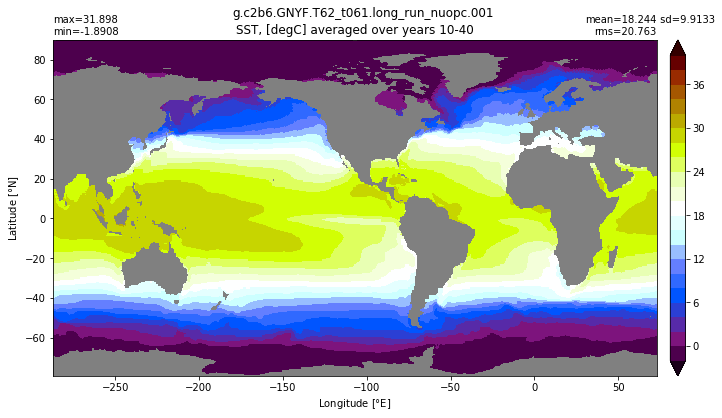

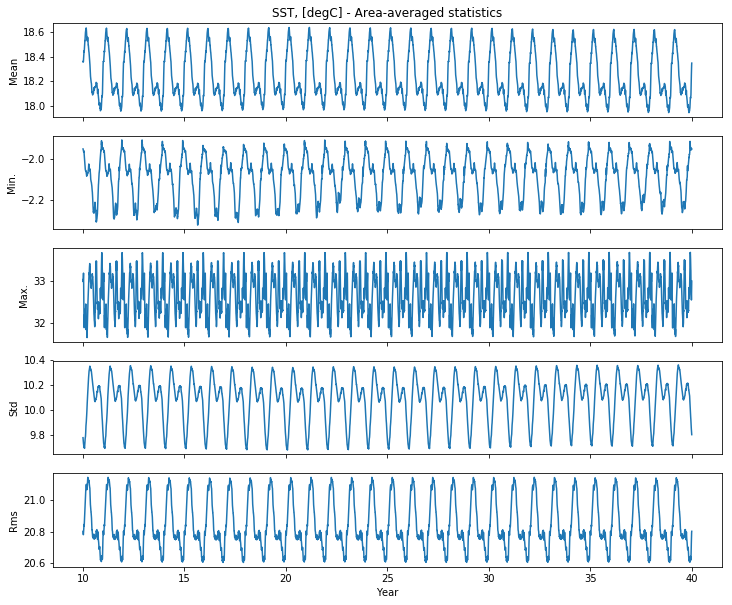

About to plot time-average for Sea Surface Salinity (SSS)... 



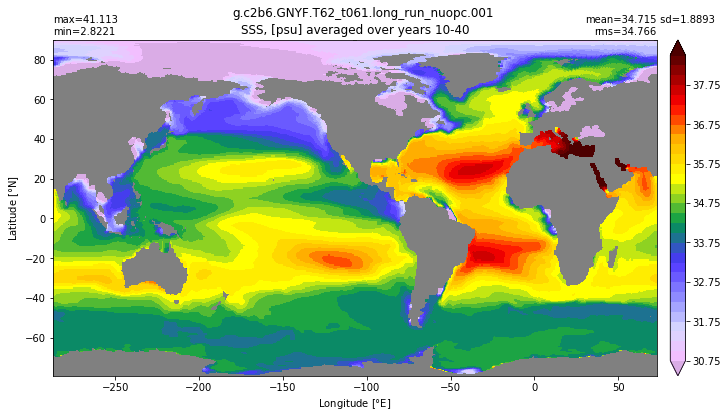

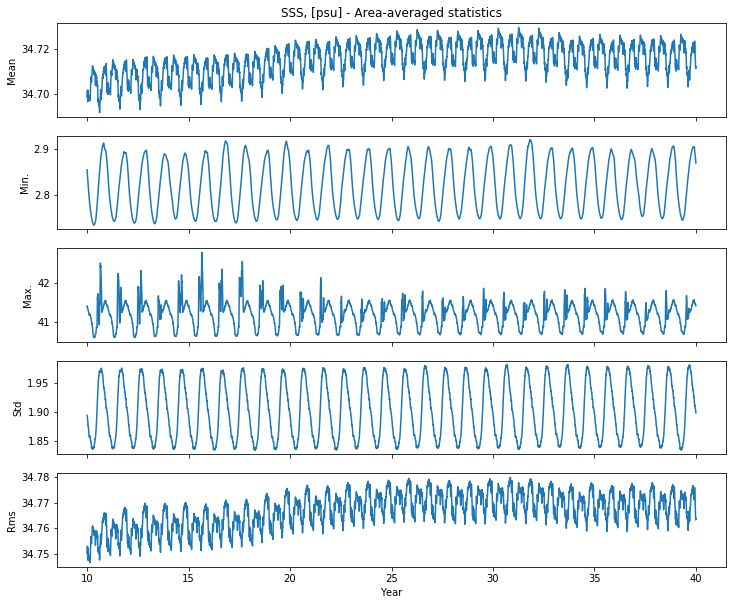

About to plot time-average for Sea Surface Height (SSH)... 



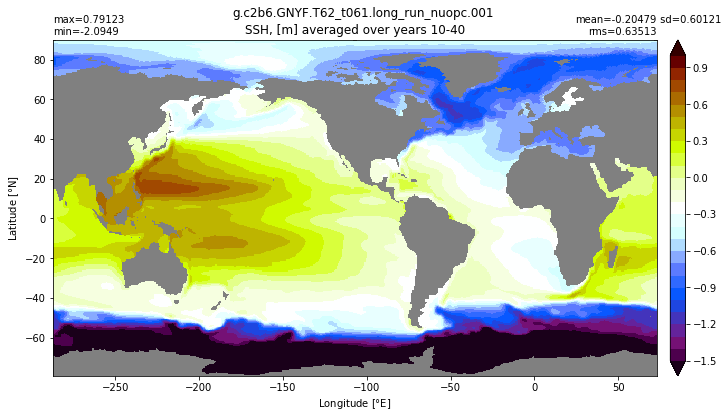

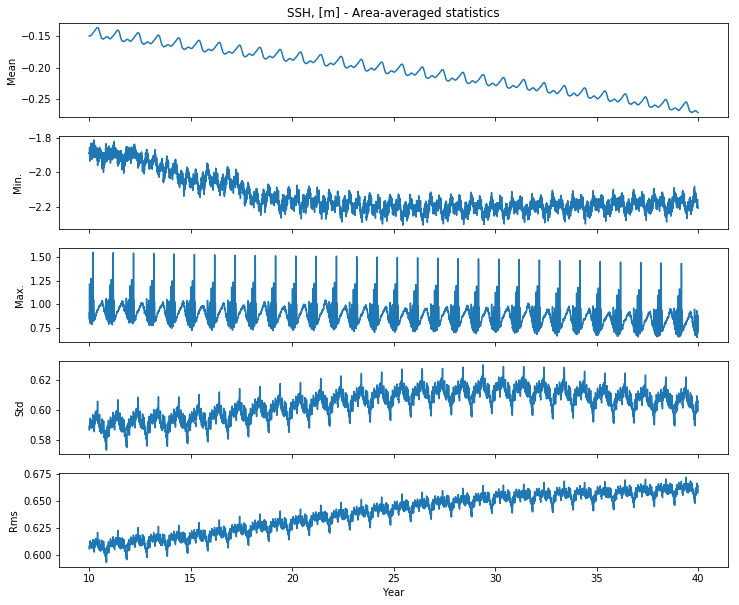

In [3]:
# load mom6 grid
grd = MOM6grid(path+static)
# plot time averages. If variables is NOT specified, all 2D variables will be plotted.
#time_mean_latlon_plot(args,grd, variables=args.variables)
time_mean_latlon(args,grd, variables=args.variables)